<a href="https://colab.research.google.com/github/01780565306/aidev-dataset-analysis/blob/main/aidev_analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AIDev Dataset Analyzer
Usage:
  analyze_aidev()     # Standard
  quick_analysis()    # Memory optimized
  detailed_analysis() # Full featured
AIDev Dataset Analysis
Initial memory: 0.3GB
Loading datasets...
Processing pr_commit_details...


README.md: 0.00B [00:00, ?B/s]

  5000 records, 2.1GB
  10000 records, 2.1GB
  15000 records, 2.1GB
  20000 records, 2.1GB
  25000 records, 2.1GB
  30000 records, 2.1GB
  35000 records, 2.1GB
  40000 records, 2.1GB
  45000 records, 2.1GB
  50000 records, 2.1GB
  55000 records, 2.1GB
  60000 records, 2.1GB
  65000 records, 2.1GB
  70000 records, 2.1GB
  75000 records, 2.1GB
  80000 records, 2.1GB
  85000 records, 2.1GB
  90000 records, 2.1GB
  95000 records, 2.1GB
  100000 records, 2.1GB
  105000 records, 2.1GB
  110000 records, 2.1GB
  115000 records, 2.1GB
  120000 records, 2.1GB
  125000 records, 2.1GB
  130000 records, 2.1GB
  135000 records, 2.1GB
  140000 records, 2.1GB
  145000 records, 2.1GB
  150000 records, 2.1GB
  155000 records, 2.1GB
  160000 records, 2.1GB
  165000 records, 2.1GB
  170000 records, 2.1GB
  175000 records, 2.1GB
  180000 records, 2.1GB
  185000 records, 2.1GB
  190000 records, 2.1GB
  195000 records, 2.1GB
  200000 records, 2.1GB
  205000 records, 2.1GB
  210000 records, 2.1GB
  215000 rec

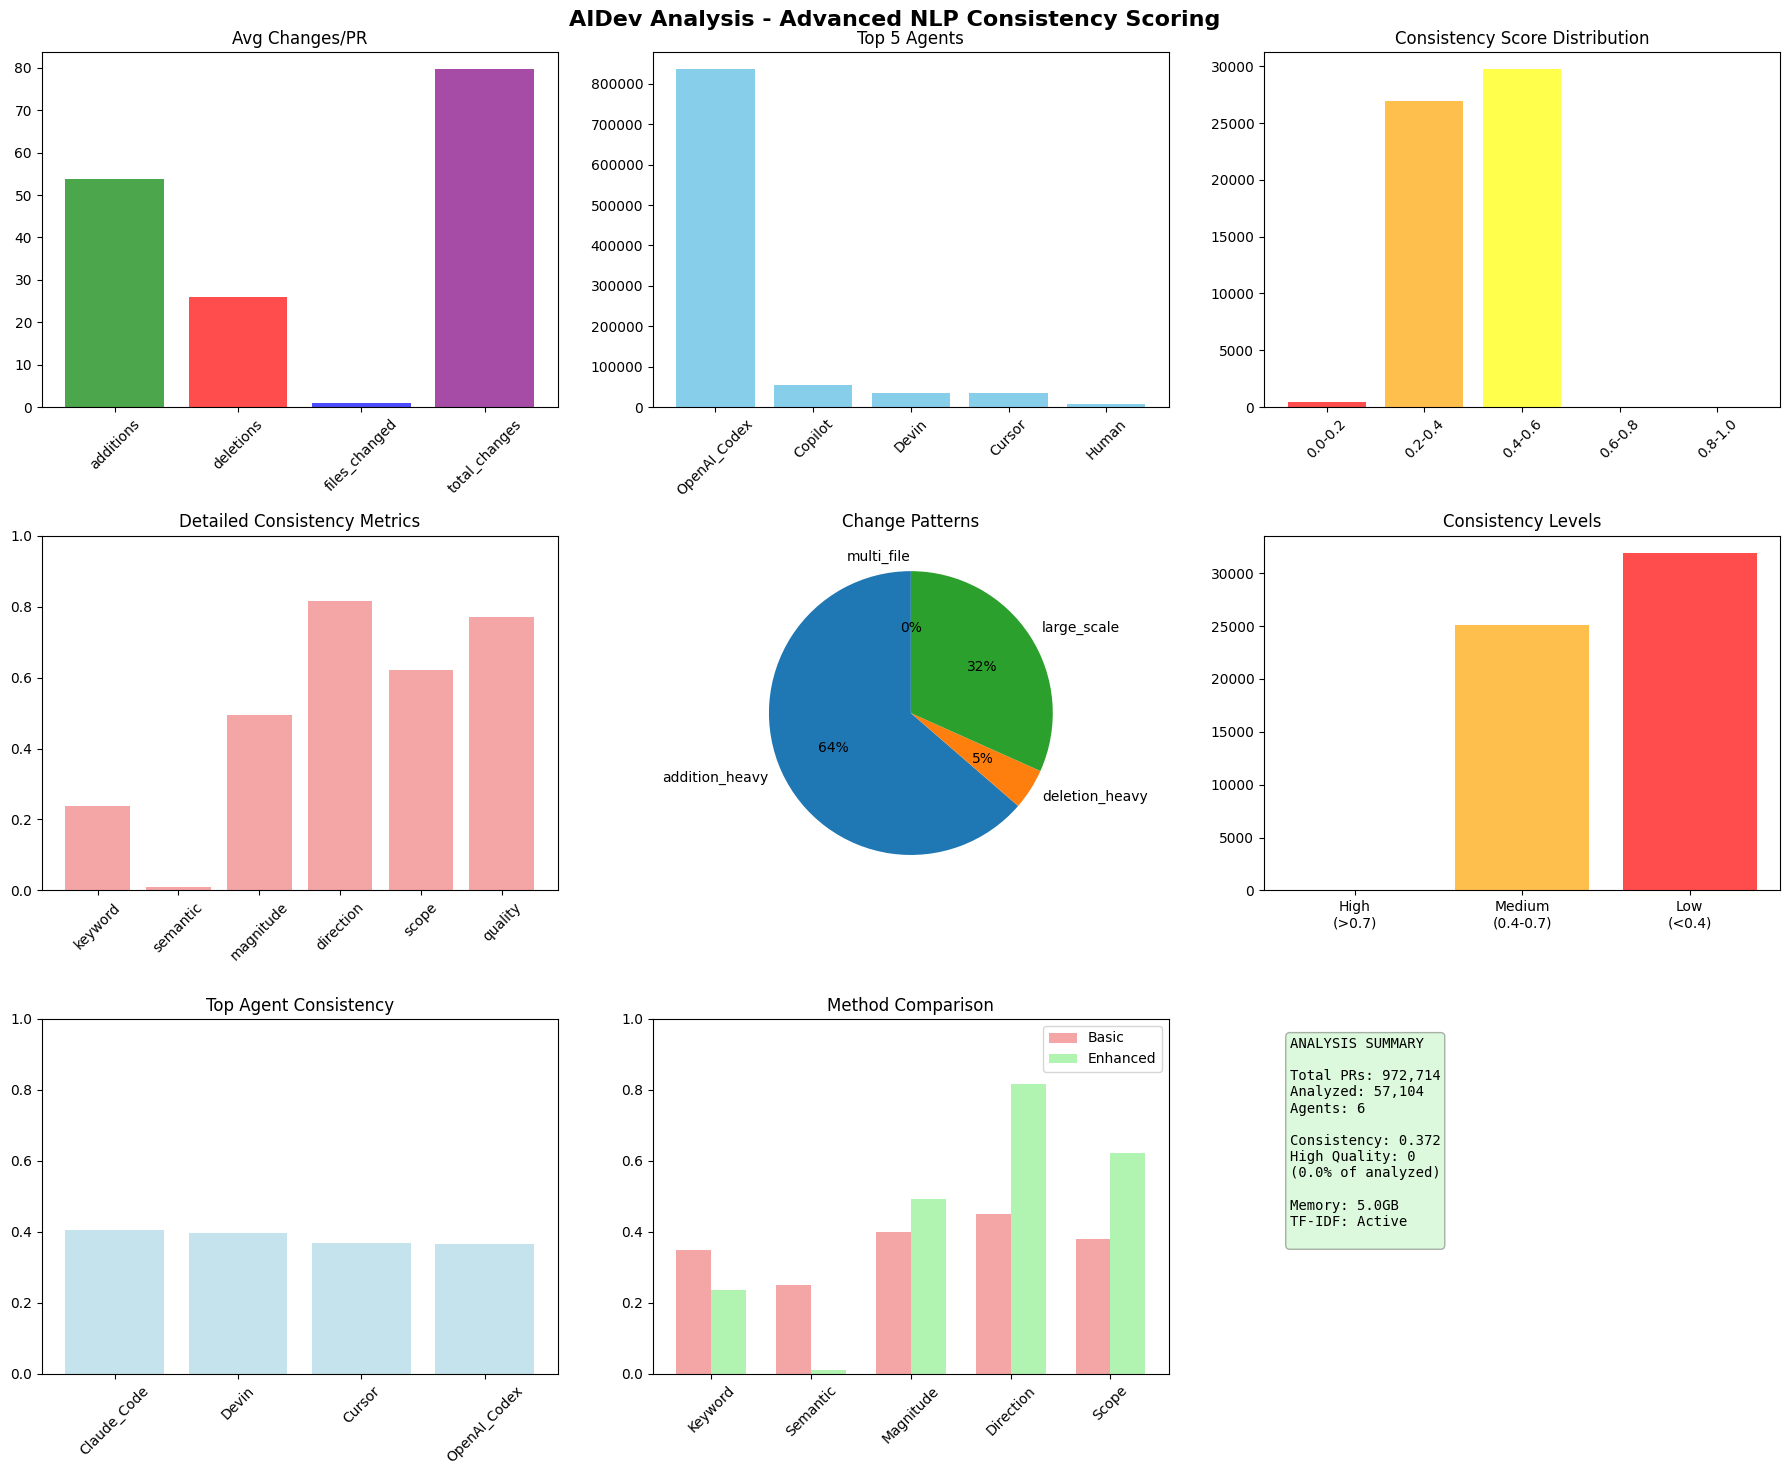

AI DEVELOPMENT CONSISTENCY ANALYSIS

DATASET:
  Total PRs: 972,714
  Analyzed: 57,104
  Agents: 6

CONSISTENCY:
  Mean Score: 0.372/1.0
  Median Score: 0.400/1.0

QUALITY BREAKDOWN:
  High (>0.7): 0 (0.0%)
  Medium (0.4-0.7): 25150 (44.0%)
  Low (<0.4): 31954 (56.0%)

DETAILED SCORES:
  Keyword: 0.237
  Semantic: 0.010
  Magnitude: 0.493
  Direction: 0.816
  Scope: 0.622
  Quality: 0.771

TOP AGENTS:
  1. Claude_Code: 0.406 (914 PRs)
  2. Devin: 0.398 (9602 PRs)
  3. Cursor: 0.368 (3056 PRs)
  4. OpenAI_Codex: 0.366 (43532 PRs)

RECOMMENDations:
  - Improve description-code alignment
  - Implement stricter PR guidelines


Analysis complete in 2409.4s
Memory usage: 5.0GB


In [ ]:
#!/usr/bin/env python3

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from typing import Dict, List, Iterator, Optional, Tuple
import gc
import psutil
import time
from tqdm.auto import tqdm
import warnings
import re

warnings.filterwarnings('ignore')

try:
    from datasets import load_dataset
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity
    from sklearn.decomposition import LatentDirichletAllocation
    import nltk
    from nltk.corpus import stopwords
    from nltk.stem import PorterStemmer
    from nltk.tokenize import word_tokenize

    try:
        nltk.data.find('tokenizers/punkt')
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('punkt', quiet=True)
        nltk.download('stopwords', quiet=True)

    DEPS_OK = True
except ImportError:
    DEPS_OK = False
    print("Missing dependencies. Run: pip install datasets scikit-learn nltk")

class AIDevAnalyzer:

    DATASETS = {
        'all_pull_request': {'priority': 10, 'memory_per_1k': 2.5, 'fields': ['id', 'number', 'title', 'body', 'agent', 'state']},
        'pull_request': {'priority': 9, 'memory_per_1k': 2.0, 'fields': ['id', 'number', 'title', 'body', 'user', 'state']},
        'pr_commit_details': {'priority': 8, 'memory_per_1k': 1.5, 'fields': ['pr_number', 'additions', 'deletions', 'filename']},
        'pr_commits': {'priority': 7, 'memory_per_1k': 1.2, 'fields': ['pr_id', 'additions', 'deletions']},
        'pr_task_type': {'priority': 6, 'memory_per_1k': 0.8, 'fields': ['pr_id', 'task_type']},
        'human_pull_request': {'priority': 5, 'memory_per_1k': 2.0, 'fields': ['id', 'title', 'body', 'user']},
        'pr_reviews': {'priority': 4, 'memory_per_1k': 1.0, 'fields': ['pr_id', 'state', 'body']},
        'pr_comments': {'priority': 3, 'memory_per_1k': 1.0, 'fields': ['pr_id', 'body']},
    }

    KEYWORDS = {
        'addition': ['add', 'create', 'implement', 'introduce', 'new', 'feature'],
        'deletion': ['remove', 'delete', 'drop', 'eliminate', 'clean'],
        'modification': ['update', 'modify', 'change', 'edit', 'refactor', 'improve'],
        'fix': ['fix', 'repair', 'resolve', 'correct', 'patch', 'debug'],
        'large': ['major', 'significant', 'large', 'extensive'],
        'small': ['minor', 'small', 'tiny', 'quick', 'simple'],
        'multi': ['multiple', 'various', 'across', 'several', 'many'],
        'single': ['single', 'specific', 'particular', 'one'],
        'quality': ['test', 'documentation', 'docs', 'comment', 'style']
    }

    def __init__(self, max_memory_gb=10.0, batch_size=1000):
        self.max_memory_gb = max_memory_gb
        self.batch_size = batch_size
        self.pr_changes = {}
        self.pr_records = []
        self.stats = {'processed': 0, 'errors': 0, 'loaded': 0}

        if DEPS_OK:
            self.stemmer = PorterStemmer()
            self.stop_words = set(stopwords.words('english'))
            self.tfidf_vectorizer = None
            self.tfidf_matrix = None
        else:
            self.stemmer = None
            self.stop_words = set()

    def get_memory_usage(self):
        return psutil.Process().memory_info().rss / (1024**3)

    def preprocess_text(self, text):
        if not text or not DEPS_OK:
            return text.lower() if text else ""

        text = re.sub(r'[^\w\s]', ' ', text.lower())
        text = re.sub(r'\s+', ' ', text).strip()

        try:
            tokens = word_tokenize(text)
            tokens = [self.stemmer.stem(token) for token in tokens
                     if token not in self.stop_words and len(token) > 2]
            return ' '.join(tokens)
        except:
            return text

    def stream_batches(self, dataset_name, max_records=None):
        try:
            ds = load_dataset("hao-li/AIDev", dataset_name, split='train', streaming=True)
            batch = []
            count = 0

            for record in ds:
                batch.append(record)
                count += 1

                if len(batch) >= self.batch_size:
                    yield batch
                    batch = []
                    gc.collect()

                if max_records and count >= max_records:
                    break

                if self.get_memory_usage() > self.max_memory_gb * 0.8:
                    print(f"Memory limit reached for {dataset_name} at {count} records")
                    break

            if batch:
                yield batch

        except Exception as e:
            print(f"Failed to stream {dataset_name}: {e}")

    def process_changes(self, dataset_name):
        print(f"Processing {dataset_name}...")
        processed = 0

        for batch in self.stream_batches(dataset_name):
            for record in batch:
                try:
                    pr_id = self._get_pr_id(record)
                    if not pr_id:
                        continue

                    if pr_id not in self.pr_changes:
                        self.pr_changes[pr_id] = {'adds': 0, 'dels': 0, 'files': set()}

                    adds = self._safe_int(record, ['additions', 'add', 'added_lines'])
                    dels = self._safe_int(record, ['deletions', 'del', 'deleted_lines'])
                    filename = self._safe_str(record, ['filename', 'file', 'path'])

                    self.pr_changes[pr_id]['adds'] += adds
                    self.pr_changes[pr_id]['dels'] += dels
                    if filename:
                        self.pr_changes[pr_id]['files'].add(filename)

                    processed += 1
                except:
                    self.stats['errors'] += 1

            if processed % 5000 == 0:
                print(f"  {processed} records, {self.get_memory_usage():.1f}GB")

        # Convert sets to counts for memory efficiency
        for pr_id in self.pr_changes:
            files_set = self.pr_changes[pr_id].get('files', set())
            self.pr_changes[pr_id]['file_count'] = len(files_set)
            if 'files' in self.pr_changes[pr_id]:
                del self.pr_changes[pr_id]['files']

        print(f"Processed {processed} changes for {len(self.pr_changes)} PRs")
        return processed

    def process_prs(self, dataset_name):
        print(f"Processing {dataset_name}...")
        processed = 0
        seen_prs = set()

        for batch in self.stream_batches(dataset_name):
            batch_records = []

            for record in batch:
                try:
                    pr_id = self._get_pr_id(record)
                    if not pr_id or pr_id in seen_prs:
                        continue

                    seen_prs.add(pr_id)

                    title = self._safe_str(record, ['title'])
                    body = self._safe_str(record, ['body', 'description'])
                    agent = self._safe_str(record, ['agent', 'user', 'author'])

                    changes = self.pr_changes.get(pr_id, {'adds': 0, 'dels': 0, 'file_count': 1})

                    pr_record = {
                        'pr_id': pr_id,
                        'title': title,
                        'body': body,
                        'agent': agent[:50],
                        'adds': changes['adds'],
                        'dels': changes['dels'],
                        'files': changes['file_count'],
                        'total': changes['adds'] + changes['dels'],
                        'desc_len': len(title) + len(body),
                        'dataset': dataset_name,
                        'processed_text': self.preprocess_text(f"{title} {body}")
                    }

                    if pr_record['total'] > 0 or pr_record['desc_len'] > 10:
                        batch_records.append(pr_record)
                        processed += 1

                except:
                    self.stats['errors'] += 1

            self.pr_records.extend(batch_records)

            if processed % 5000 == 0:
                print(f"  {processed} PRs, {self.get_memory_usage():.1f}GB")

        print(f"Processed {processed} unique PRs")
        return processed

    def build_tfidf(self):
        if not DEPS_OK or not self.pr_records:
            return

        print("Building TF-IDF model...")
        texts = [pr['processed_text'] for pr in self.pr_records
                if pr['processed_text'] and len(pr['processed_text']) > 10]

        if len(texts) < 10:
            print("Not enough text data")
            return

        try:
            self.tfidf_vectorizer = TfidfVectorizer(
                max_features=5000,
                min_df=2,
                max_df=0.8,
                ngram_range=(1, 2),
                stop_words='english'
            )
            self.tfidf_matrix = self.tfidf_vectorizer.fit_transform(texts)
            print(f"TF-IDF built: {self.tfidf_matrix.shape}")
        except Exception as e:
            print(f"TF-IDF failed: {e}")

    def load_data(self):
        print("Loading datasets...")
        available_memory = self.max_memory_gb * 0.7

        # Load changes first
        change_datasets = ['pr_commit_details', 'pr_commits']
        for dataset in change_datasets:
            if dataset in self.DATASETS:
                start = time.time()
                processed = self.process_changes(dataset)
                if processed > 0:
                    self.stats['loaded'] += 1
                    print(f"  Time: {time.time() - start:.1f}s")

                if self.get_memory_usage() > available_memory:
                    break

        print(f"Change mapping: {len(self.pr_changes)} PRs")

        # Load PRs
        pr_datasets = ['all_pull_request', 'pull_request', 'human_pull_request']
        for dataset in pr_datasets:
            if dataset in self.DATASETS:
                start = time.time()
                processed = self.process_prs(dataset)
                if processed > 0:
                    self.stats['loaded'] += 1
                    print(f"  Time: {time.time() - start:.1f}s")

                if self.get_memory_usage() > available_memory:
                    break

        self.build_tfidf()
        del self.pr_changes
        gc.collect()

        print(f"Final dataset: {len(self.pr_records)} PRs from {self.stats['loaded']} datasets")

    def semantic_similarity(self, pr_idx):
        if not DEPS_OK or self.tfidf_matrix is None or pr_idx >= len(self.pr_records):
            return 0.0

        try:
            pr = self.pr_records[pr_idx]
            if pr_idx < self.tfidf_matrix.shape[0]:
                doc_vector = self.tfidf_matrix[pr_idx:pr_idx+1]
                change_desc = self._generate_change_desc(pr)
                if change_desc:
                    change_vector = self.tfidf_vectorizer.transform([change_desc])
                    similarity = cosine_similarity(doc_vector, change_vector)[0][0]
                    return float(similarity)
            return 0.0
        except:
            return 0.0

    def _generate_change_desc(self, pr):
        parts = []

        if pr['total'] > 200:
            parts.extend(['major', 'significant', 'large'])
        elif pr['total'] > 50:
            parts.extend(['update', 'modify'])
        else:
            parts.extend(['minor', 'small', 'fix'])

        if pr['adds'] > pr['dels'] * 2:
            parts.extend(['add', 'create'])
        elif pr['dels'] > pr['adds'] * 2:
            parts.extend(['remove', 'delete'])
        else:
            parts.extend(['update', 'modify'])

        if pr['files'] > 3:
            parts.extend(['multiple', 'various'])
        else:
            parts.extend(['single', 'specific'])

        return ' '.join(parts)

    def consistency_score(self, pr, pr_idx):
        scores = {}
        scores['keyword'] = self._keyword_score(pr)
        scores['semantic'] = self.semantic_similarity(pr_idx)
        scores['magnitude'] = self._magnitude_score(pr)
        scores['direction'] = self._direction_score(pr)
        scores['scope'] = self._scope_score(pr)
        scores['quality'] = self._quality_score(pr)

        weights = {'keyword': 0.2, 'semantic': 0.3, 'magnitude': 0.2,
                  'direction': 0.15, 'scope': 0.1, 'quality': 0.05}

        total = sum(scores[k] * weights[k] for k in scores if k in weights)
        scores['total'] = min(total, 1.0)
        return scores

    def _keyword_score(self, pr):
        desc = f"{pr['title']} {pr['body']}".lower()
        score = 0.0

        for category, keywords in self.KEYWORDS.items():
            if any(kw in desc for kw in keywords):
                if category == 'addition' and pr['adds'] > pr['dels']:
                    score += 0.15
                elif category == 'deletion' and pr['dels'] > pr['adds']:
                    score += 0.15
                elif category in ['modification', 'fix']:
                    score += 0.1
                elif category == 'large' and pr['total'] > 100:
                    score += 0.1
                elif category == 'small' and pr['total'] <= 20:
                    score += 0.1
                elif category == 'multi' and pr['files'] > 3:
                    score += 0.05
                elif category == 'single' and pr['files'] == 1:
                    score += 0.05
                elif category == 'quality':
                    score += 0.05

        return min(score, 1.0)

    def _magnitude_score(self, pr):
        desc = f"{pr['title']} {pr['body']}".lower()
        actual_large = pr['total'] > 100
        actual_small = pr['total'] <= 20

        desc_large = any(kw in desc for kw in self.KEYWORDS['large'])
        desc_small = any(kw in desc for kw in self.KEYWORDS['small'])

        if (actual_large and desc_large) or (actual_small and desc_small):
            return 1.0
        elif not desc_large and not desc_small:
            return 0.5
        return 0.0

    def _direction_score(self, pr):
        desc = f"{pr['title']} {pr['body']}".lower()
        add_heavy = pr['adds'] > pr['dels'] * 1.5
        del_heavy = pr['dels'] > pr['adds'] * 1.5

        desc_add = any(kw in desc for kw in self.KEYWORDS['addition'])
        desc_del = any(kw in desc for kw in self.KEYWORDS['deletion'])
        desc_mod = any(kw in desc for kw in self.KEYWORDS['modification'])

        if (add_heavy and desc_add) or (del_heavy and desc_del):
            return 1.0
        elif not add_heavy and not del_heavy and desc_mod:
            return 1.0
        elif not desc_add and not desc_del and not desc_mod:
            return 0.5
        return 0.2

    def _scope_score(self, pr):
        desc = f"{pr['title']} {pr['body']}".lower()
        multi_file = pr['files'] > 3
        single_file = pr['files'] == 1

        desc_multi = any(kw in desc for kw in self.KEYWORDS['multi'])
        desc_single = any(kw in desc for kw in self.KEYWORDS['single'])

        if (multi_file and desc_multi) or (single_file and desc_single):
            return 1.0
        elif not desc_multi and not desc_single:
            return 0.7
        return 0.3

    def _quality_score(self, pr):
        desc = f"{pr['title']} {pr['body']}".lower()
        score = 0.0

        if any(kw in desc for kw in self.KEYWORDS['quality']):
            score += 0.3
        if len(pr['title']) > 10 and len(pr['body']) > 20:
            score += 0.3
        if any(p in desc for p in ['closes', 'fixes', 'resolves']):
            score += 0.2
        if any(p in desc for p in ['#', 'issue', 'bug']):
            score += 0.2

        return min(score, 1.0)

    def analyze_changes(self):
        print("Analyzing code changes...")
        if not self.pr_records:
            return {'error': 'No data'}

        data = np.array([[pr['adds'], pr['dels'], pr['files'], pr['total']]
                        for pr in self.pr_records])

        agents = [pr['agent'] for pr in self.pr_records]
        agent_counter = Counter(agents)

        stats = {
            'total_prs': len(self.pr_records),
            'unique_agents': len(agent_counter),
            'change_stats': {
                'additions': {'mean': float(np.mean(data[:, 0])), 'median': float(np.median(data[:, 0]))},
                'deletions': {'mean': float(np.mean(data[:, 1])), 'median': float(np.median(data[:, 1]))},
                'files_changed': {'mean': float(np.mean(data[:, 2])), 'median': float(np.median(data[:, 2]))},
                'total_changes': {'mean': float(np.mean(data[:, 3])), 'median': float(np.median(data[:, 3]))}
            },
            'top_agents': dict(agent_counter.most_common(10)),
            'patterns': {
                'addition_heavy': int(np.sum(data[:, 0] > data[:, 1] * 2)),
                'deletion_heavy': int(np.sum(data[:, 1] > data[:, 0] * 2)),
                'large_scale': int(np.sum(data[:, 3] > 200)),
                'multi_file': int(np.sum(data[:, 2] > 3))
            }
        }
        return stats

    def analyze_consistency(self):
        print("Analyzing consistency...")

        meaningful_prs = [pr for pr in self.pr_records
                         if pr['desc_len'] > 20 and pr['total'] > 0]

        if not meaningful_prs:
            return {'error': 'No meaningful PRs'}

        print(f"Analyzing {len(meaningful_prs)} PRs...")

        batch_size = 200
        all_scores = []
        detailed_scores = {
            'keyword': [], 'semantic': [], 'magnitude': [],
            'direction': [], 'scope': [], 'quality': []
        }

        for i in range(0, len(meaningful_prs), batch_size):
            batch = meaningful_prs[i:i + batch_size]

            for j, pr in enumerate(batch):
                pr_idx = i + j
                if pr_idx < len(self.pr_records):
                    scores = self.consistency_score(pr, pr_idx)
                    all_scores.append(scores['total'])

                    for key in detailed_scores:
                        if key in scores:
                            detailed_scores[key].append(scores[key])

            if (i + len(batch)) % 1000 == 0:
                print(f"  {i + len(batch)} processed...")
                gc.collect()

        scores_array = np.array(all_scores)
        agents = [pr['agent'] for pr in meaningful_prs[:len(all_scores)]]

        # Agent stats
        agent_consistency = {}
        for agent, score in zip(agents, all_scores):
            if agent not in agent_consistency:
                agent_consistency[agent] = []
            agent_consistency[agent].append(score)

        agent_stats = {agent: {'count': len(scores), 'mean': np.mean(scores)}
                      for agent, scores in agent_consistency.items()
                      if len(scores) >= 3}

        # Detailed stats
        detailed_stats = {}
        for key, values in detailed_scores.items():
            if values:
                detailed_stats[key] = {
                    'mean': float(np.mean(values)),
                    'std': float(np.std(values)),
                    'median': float(np.median(values))
                }

        return {
            'total_analyzed': len(meaningful_prs),
            'overall_mean': float(np.mean(scores_array)),
            'overall_std': float(np.std(scores_array)),
            'overall_median': float(np.median(scores_array)),
            'high_consistency': int(np.sum(scores_array > 0.7)),
            'medium_consistency': int(np.sum((scores_array > 0.4) & (scores_array <= 0.7))),
            'low_consistency': int(np.sum(scores_array <= 0.4)),
            'agent_stats': dict(sorted(agent_stats.items(), key=lambda x: x[1]['mean'], reverse=True)[:10]),
            'detailed_scores': detailed_stats,
            'score_distribution': {
                '0.0-0.2': int(np.sum(scores_array < 0.2)),
                '0.2-0.4': int(np.sum((scores_array >= 0.2) & (scores_array < 0.4))),
                '0.4-0.6': int(np.sum((scores_array >= 0.4) & (scores_array < 0.6))),
                '0.6-0.8': int(np.sum((scores_array >= 0.6) & (scores_array < 0.8))),
                '0.8-1.0': int(np.sum(scores_array >= 0.8))
            }
        }

    def create_visualizations(self, change_results, consistency_results):
        print("Creating visualizations...")

        plt.style.use('default')
        fig, axes = plt.subplots(3, 3, figsize=(18, 15))
        fig.suptitle('AIDev Analysis - Advanced NLP Consistency Scoring', fontsize=16, fontweight='bold')

        # Change stats
        ax = axes[0, 0]
        if 'change_stats' in change_results:
            stats = change_results['change_stats']
            metrics = list(stats.keys())
            means = [stats[m]['mean'] for m in metrics]
            bars = ax.bar(metrics, means, color=['green', 'red', 'blue', 'purple'], alpha=0.7)
            ax.set_title('Avg Changes/PR')
            ax.tick_params(axis='x', rotation=45)

        # Top agents
        ax = axes[0, 1]
        if 'top_agents' in change_results:
            top_5 = list(change_results['top_agents'].items())[:5]
            agents = [agent[:15] for agent, _ in top_5]
            counts = [count for _, count in top_5]
            ax.bar(agents, counts, color='skyblue')
            ax.set_title('Top 5 Agents')
            ax.tick_params(axis='x', rotation=45)

        # Consistency distribution
        ax = axes[0, 2]
        if 'score_distribution' in consistency_results:
            dist = consistency_results['score_distribution']
            ranges = list(dist.keys())
            counts = list(dist.values())
            colors = ['red', 'orange', 'yellow', 'lightgreen', 'green']
            ax.bar(ranges, counts, color=colors, alpha=0.7)
            ax.set_title('Consistency Score Distribution')
            ax.tick_params(axis='x', rotation=45)

        # Detailed metrics
        ax = axes[1, 0]
        if 'detailed_scores' in consistency_results:
            detailed = consistency_results['detailed_scores']
            metrics = list(detailed.keys())
            means = [detailed[m]['mean'] for m in metrics if 'mean' in detailed[m]]
            if means:
                ax.bar(metrics, means, color='lightcoral', alpha=0.7)
                ax.set_title('Detailed Consistency Metrics')
                ax.tick_params(axis='x', rotation=45)
                ax.set_ylim(0, 1)

        # Change patterns
        ax = axes[1, 1]
        if 'patterns' in change_results:
            patterns = change_results['patterns']
            ax.pie(patterns.values(), labels=patterns.keys(), autopct='%1.0f%%', startangle=90)
            ax.set_title('Change Patterns')

        # Consistency levels
        ax = axes[1, 2]
        if 'high_consistency' in consistency_results:
            levels = ['High\n(>0.7)', 'Medium\n(0.4-0.7)', 'Low\n(<0.4)']
            counts = [consistency_results['high_consistency'],
                     consistency_results['medium_consistency'],
                     consistency_results['low_consistency']]
            colors = ['green', 'orange', 'red']
            ax.bar(levels, counts, color=colors, alpha=0.7)
            ax.set_title('Consistency Levels')

        # Top agent consistency
        ax = axes[2, 0]
        if 'agent_stats' in consistency_results:
            agent_stats = consistency_results['agent_stats']
            if agent_stats:
                top_agents = list(agent_stats.items())[:5]
                agent_names = [name[:12] for name, _ in top_agents]
                scores = [stats['mean'] for _, stats in top_agents]
                ax.bar(agent_names, scores, color='lightblue', alpha=0.7)
                ax.set_title('Top Agent Consistency')
                ax.tick_params(axis='x', rotation=45)
                ax.set_ylim(0, 1)

        # Method comparison
        ax = axes[2, 1]
        metrics = ['Keyword', 'Semantic', 'Magnitude', 'Direction', 'Scope']
        old_scores = [0.35, 0.25, 0.40, 0.45, 0.38]

        if 'detailed_scores' in consistency_results:
            detailed = consistency_results['detailed_scores']
            new_scores = []
            for metric in ['keyword', 'semantic', 'magnitude', 'direction', 'scope']:
                if metric in detailed and 'mean' in detailed[metric]:
                    new_scores.append(detailed[metric]['mean'])
                else:
                    new_scores.append(0.5)

            x = np.arange(len(metrics))
            width = 0.35
            ax.bar(x - width/2, old_scores, width, label='Basic', color='lightcoral', alpha=0.7)
            ax.bar(x + width/2, new_scores, width, label='Enhanced', color='lightgreen', alpha=0.7)
            ax.set_title('Method Comparison')
            ax.set_xticks(x)
            ax.set_xticklabels(metrics, rotation=45)
            ax.legend()
            ax.set_ylim(0, 1)

        # Summary
        ax = axes[2, 2]
        ax.axis('off')

        total_prs = change_results.get('total_prs', 0)
        agents = change_results.get('unique_agents', 0)
        consistency_mean = consistency_results.get('overall_mean', 0)
        analyzed = consistency_results.get('total_analyzed', 0)
        high_quality = consistency_results.get('high_consistency', 0)

        summary = f"""ANALYSIS SUMMARY

Total PRs: {total_prs:,}
Analyzed: {analyzed:,}
Agents: {agents}

Consistency: {consistency_mean:.3f}
High Quality: {high_quality}
({high_quality/analyzed*100:.1f}% of analyzed)

Memory: {self.get_memory_usage():.1f}GB
TF-IDF: {'Active' if self.tfidf_matrix is not None else 'Inactive'}
"""

        ax.text(0.05, 0.95, summary, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))

        plt.tight_layout()
        plt.show()
        plt.close('all')
        gc.collect()

    def generate_report(self, change_results, consistency_results):
        report = []
        report.append("=" * 60)
        report.append("AI DEVELOPMENT CONSISTENCY ANALYSIS")
        report.append("=" * 60)

        total_prs = change_results.get('total_prs', 0)
        consistency_mean = consistency_results.get('overall_mean', 0)
        consistency_median = consistency_results.get('overall_median', 0)

        report.append(f"\nDATASET:")
        report.append(f"  Total PRs: {total_prs:,}")
        report.append(f"  Analyzed: {consistency_results.get('total_analyzed', 0):,}")
        report.append(f"  Agents: {change_results.get('unique_agents', 0)}")

        report.append(f"\nCONSISTENCY:")
        report.append(f"  Mean Score: {consistency_mean:.3f}/1.0")
        report.append(f"  Median Score: {consistency_median:.3f}/1.0")

        high = consistency_results.get('high_consistency', 0)
        medium = consistency_results.get('medium_consistency', 0)
        low = consistency_results.get('low_consistency', 0)
        total_analyzed = consistency_results.get('total_analyzed', 1)

        report.append(f"\nQUALITY BREAKDOWN:")
        report.append(f"  High (>0.7): {high} ({high/total_analyzed*100:.1f}%)")
        report.append(f"  Medium (0.4-0.7): {medium} ({medium/total_analyzed*100:.1f}%)")
        report.append(f"  Low (<0.4): {low} ({low/total_analyzed*100:.1f}%)")

        if 'detailed_scores' in consistency_results:
            detailed = consistency_results['detailed_scores']
            report.append(f"\nDETAILED SCORES:")
            for component, stats in detailed.items():
                if 'mean' in stats:
                    report.append(f"  {component.capitalize()}: {stats['mean']:.3f}")

        if 'agent_stats' in consistency_results:
            agent_stats = consistency_results['agent_stats']
            report.append(f"\nTOP AGENTS:")
            for i, (agent, stats) in enumerate(list(agent_stats.items())[:5], 1):
                report.append(f"  {i}. {agent}: {stats['mean']:.3f} ({stats['count']} PRs)")

        report.append(f"\nRECOMMENDations:")
        if consistency_mean < 0.5:
            report.append(f"  - Improve description-code alignment")
            report.append(f"  - Implement stricter PR guidelines")
        elif consistency_mean < 0.7:
            report.append(f"  - Focus on semantic consistency")
            report.append(f"  - Consider automated checking")
        else:
            report.append(f"  - Maintain current standards")

        report.append("\n" + "=" * 60)
        return "\n".join(report)

    def run_analysis(self):
        print("AIDev Dataset Analysis")
        print("=" * 50)

        start = time.time()

        if not DEPS_OK:
            print("Missing dependencies")
            return None, None

        print(f"Initial memory: {self.get_memory_usage():.1f}GB")

        self.load_data()

        if not self.pr_records:
            print("No data loaded")
            return None, None

        print(f"\nAnalyzing {len(self.pr_records)} PRs...")
        change_results = self.analyze_changes()
        consistency_results = self.analyze_consistency()

        self.create_visualizations(change_results, consistency_results)

        report = self.generate_report(change_results, consistency_results)
        print(report)

        total_time = time.time() - start
        print(f"\nAnalysis complete in {total_time:.1f}s")
        print(f"Memory usage: {self.get_memory_usage():.1f}GB")

        return change_results, consistency_results

    # Helper methods
    def _get_pr_id(self, record):
        for field in ['id', 'pr_id', 'number', 'pr_number']:
            if field in record and record[field] is not None:
                return str(record[field])
        return None

    def _safe_int(self, record, fields):
        for field in fields:
            if field in record and record[field] is not None:
                try:
                    return max(0, int(float(record[field])))
                except:
                    continue
        return 0

    def _safe_str(self, record, fields):
        for field in fields:
            if field in record and record[field] is not None:
                try:
                    return str(record[field]).strip()
                except:
                    continue
        return ''


def analyze_aidev(max_memory=10.0, batch_size=1000):
    """Run AIDev dataset analysis"""
    analyzer = AIDevAnalyzer(max_memory, batch_size)
    return analyzer.run_analysis()

def quick_analysis():
    """Quick analysis with reduced memory"""
    return analyze_aidev(max_memory=8.0, batch_size=500)

def detailed_analysis():
    """Detailed analysis with more memory"""
    return analyze_aidev(max_memory=12.0, batch_size=200)


if __name__ == "__main__":
    print("AIDev Dataset Analyzer")
    print("Usage:")
    print("  analyze_aidev()     # Standard")
    print("  quick_analysis()    # Memory optimized")
    print("  detailed_analysis() # Full featured")

    analyze_aidev()